202007Gp1 bloom timing

In [1]:
import datetime as dt
from erddapy import ERDDAP
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

from salishsea_tools import places

%matplotlib inline

### Set up Model Results Getting

In [10]:
directory = '202007G-p1'
dir_path = Path(f"/data/sallen/results/MEOPAR/202007/{directory}")

In [11]:
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "nav_lat",
    "bounds_lat",
    "nav_lon",
    "bounds_lon",
    "area",
    "deptht_bounds",
]
chunks = {
    "time_counter": 1,
    "deptht": 1,
}

In [12]:
def prep_timeseries(dir_path, file_pattern, n_days): 
    ds_files = sorted(dir_path.glob(file_pattern))
    ds = xr.open_mfdataset(
        ds_files[:n_days],
        chunks=chunks,
        drop_variables=drop_vars,
    )
    S3y, S3x = places.PLACES['S3']['NEMO grid ji'][0], places.PLACES['S3']['NEMO grid ji'][1]
    fourkm = 8
    timeseries = ds.isel(deptht = 1, y = slice(S3y-fourkm, S3y+fourkm+1), 
                             x =  slice(S3x-fourkm, S3x+fourkm+1))
    
    return timeseries

### Set up Observations Getting

In [13]:
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "tabledap"

dataset_id = "ubcONCTWDP1mV18-01"

response = "nc"

variables = [
    "latitude",
    "longitude",
    "chlorophyll",
    "time",
]

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

### Plotting Functions

In [14]:
def model_plot(timeseries2015):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.diatoms[:, j, i].plot(ax=axs[0], color='blue', marker='o')
            timeseries2015.diatoms[:, j, i].plot(ax=axs[1], color='blue', marker='o')
    ax2 = axs[0].twinx()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.nitrate[:, j, i].plot(ax=ax2, color='lightblue', marker='o')
    axs[0].grid()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            (timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i].plot(ax=axs[1], color='purple', marker='o', alpha=0.5);

In [15]:
def model_obs_comparison(timeseries2015, obs_pd, N2Chl=2.5):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    obs_pd['chlorophyll (ug/l)'].plot(ax=ax, marker='o', color='green', linewidth=0);
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            ((timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i]*N2Chl).plot(ax=ax, color='purple', 
                                                                                                              marker='.', alpha=0.5, linewidth=0);

# 2015

## Model Results

In [18]:
year = 2015
months_regex = '0[23]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [19]:
timeseries.load(scheduler='processes', num_workers=4);

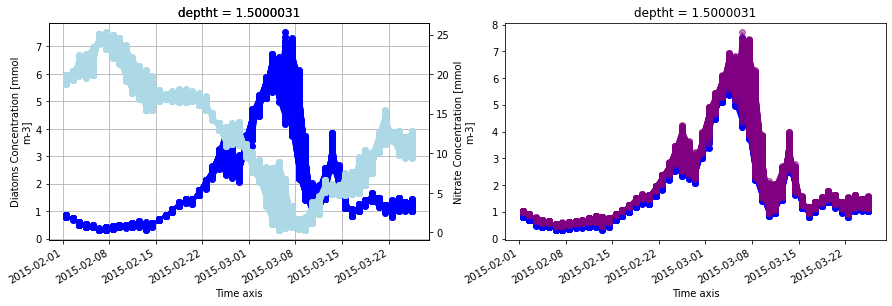

In [20]:
model_plot(timeseries)

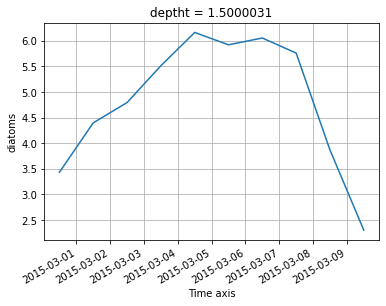

In [21]:
timeseries.diatoms[28-1:28-1+10].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom is March 4.  This bloom is five days early.

## Observations

In [22]:
constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [23]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [24]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

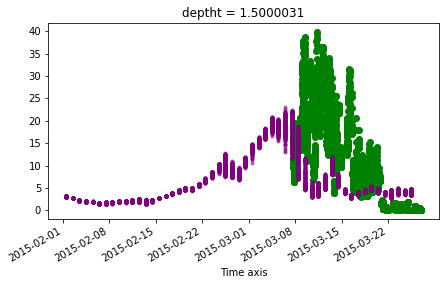

In [25]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

In [26]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()

time (UTC)
2015-03-07 00:00:00+00:00    10.234541
2015-03-08 00:00:00+00:00    17.916686
2015-03-09 00:00:00+00:00    25.061112
2015-03-10 00:00:00+00:00    19.623974
2015-03-11 00:00:00+00:00    26.599833
2015-03-12 00:00:00+00:00    25.934374
2015-03-13 00:00:00+00:00    18.578563
2015-03-14 00:00:00+00:00    14.519697
2015-03-15 00:00:00+00:00    17.463163
2015-03-16 00:00:00+00:00    16.022449
2015-03-17 00:00:00+00:00     7.264905
2015-03-18 00:00:00+00:00     5.538758
2015-03-19 00:00:00+00:00     7.878389
2015-03-20 00:00:00+00:00     6.946658
2015-03-21 00:00:00+00:00     0.604299
2015-03-22 00:00:00+00:00     0.907641
2015-03-23 00:00:00+00:00     0.484150
2015-03-24 00:00:00+00:00     0.637791
2015-03-25 00:00:00+00:00     0.376099
2015-03-26 00:00:00+00:00     0.276408
Freq: D, Name: chlorophyll (ug/l), dtype: float64

Bloom is March 9.

# 2016

## Model Results

In [27]:
year = 2016
months_regex = '0[34]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [28]:
timeseries.load(scheduler='processes', num_workers=4);

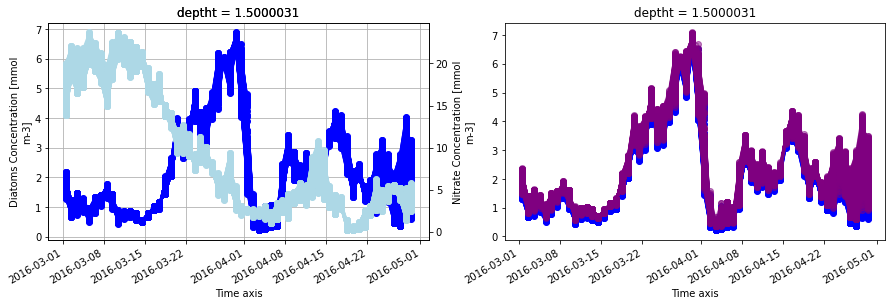

In [29]:
model_plot(timeseries)

In [30]:
timeseries.diatoms[29-1:32-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 3)>
array([5.7617855, 6.56363  , 5.0503864], dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2016-03-29T12:00:00 ... 2016-...

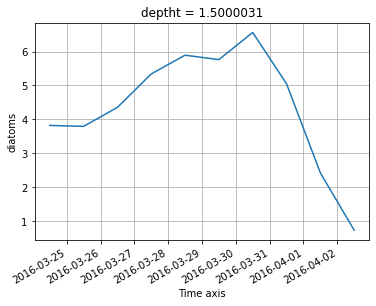

In [31]:
timeseries.diatoms[28-5:28-5+10].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom date is March 30.  This value is 6 days late.  Looks okay though, see below.

## Observations

In [32]:
constraints = {
    "time>=": "2016-03-01T00:00:00Z",
    "time<=": "2016-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [33]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [34]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

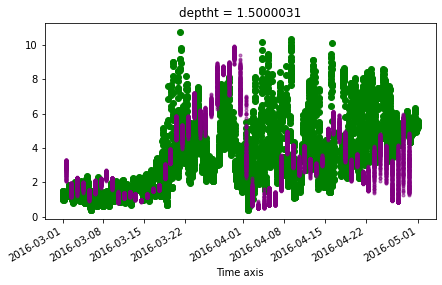

In [35]:
model_obs_comparison(timeseries, obs_pd, N2Chl=1.4)

In [36]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()[20:29]

time (UTC)
2016-03-21 00:00:00+00:00    4.978662
2016-03-22 00:00:00+00:00    4.493710
2016-03-23 00:00:00+00:00    4.065250
2016-03-24 00:00:00+00:00    5.287270
2016-03-25 00:00:00+00:00    3.523971
2016-03-26 00:00:00+00:00    2.696661
2016-03-27 00:00:00+00:00    4.394448
2016-03-28 00:00:00+00:00    5.547918
2016-03-29 00:00:00+00:00    5.706081
Freq: D, Name: chlorophyll (ug/l), dtype: float64

Bloom date is March 24.

# 2017

## Model Results

In [41]:
year = 2017
months_regex = '0[234]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [42]:
timeseries.load(scheduler='processes', num_workers=4);

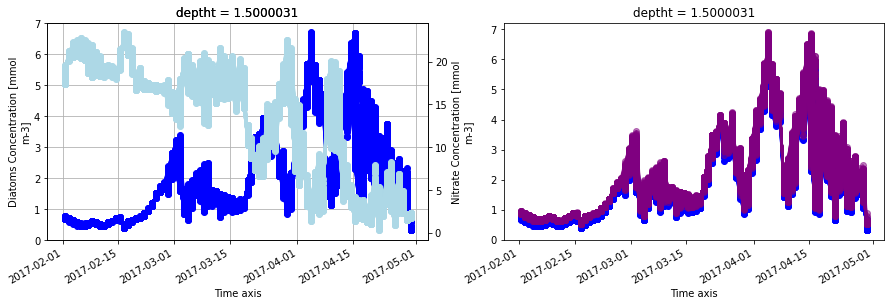

In [43]:
model_plot(timeseries)

In [44]:
timeseries.diatoms[32-1:42-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 10)>
array([1.1002164, 1.4300628, 1.7271589, 1.8345104, 1.4625285, 1.7535081,
       1.4371417, 1.4679822, 1.2694911, 1.2840488], dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2017-03-04T12:00:00 ... 2017-...

Split bloom.

## Observations

In [45]:
constraints = {
    "time>=": "2017-02-01T00:00:00Z",
    "time<=": "2017-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [46]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

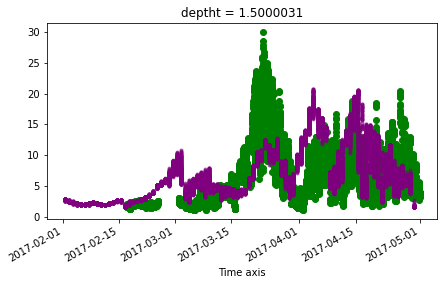

In [47]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

They all look pretty good.